# Building a steel temperature prediction model

In order to optimize production costs, the metallurgical plant Tak Temper Steel LLC decided to reduce electricity consumption at the stage of steel processing. It is necessary to build a model that predicts the steel temperature.

## Description of the processing step

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus.

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again.This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks.

The data consists of files obtained from different sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` — data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. There can be several lines in files with the same `key` value: they correspond to different processing iterations.

## Initial data analysis<a id="preprocessing"></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data_arc = pd.read_csv('final_steel/data_arc.csv')
    data_bulk = pd.read_csv('final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('final_steel/data_gas.csv')
    data_temp = pd.read_csv('final_steel/data_temp.csv')
    data_wire = pd.read_csv('final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Starting the initial analysis, we import the necessary libraries (including the experience of the library for the future) and load the initial data.

In [3]:
def columns(data):
    data.columns = data.columns.str.lower().str.replace(' ', '_')

Let's create a function to rename columns, as their "non-standard" formatting is marked.

In [4]:
def initial(data):
    print('Общая информация о датафрейме')
    display(data.info())
    print('Первые строки датафрейма')
    display(data.head(20))
    print('Статистические данные датафрейма')
    display(data.describe().round(2))
    print('Количество пропущенных значений по столбцам')
    display(data.isna().sum())
    print('Количество дубликатов в датафрейме')
    display(data.duplicated().sum())

We will also create a function for displaying general information about the dataframe using the main methods: .info(), .head(), .describe(), .isna() and .duplicated().

In [5]:
def graphical(data, column):
    plt.figure(figsize=(15,5))
    sns.distplot(data[column])
    plt.title(column)
    plt.show()
    plt.figure(figsize=(15,3))
    sns.boxplot(data[column])
    plt.title(column)
    plt.show()

Additionally, we will create a function for displaying graphical information: histograms and a "box with a mustache".

### Electrode Data

In [6]:
columns(data_arc)

At the very beginning, we will rename the columns.

In [7]:
initial(data_arc)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Первые строки датафрейма


,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Статистические данные датафрейма


,key,активная_мощность,реактивная_мощность
count,14876.00,14876.00,14876.00
mean,1615.22,0.67,0.45
std,934.57,0.41,5.88
min,1.00,0.03,-715.50
25%,806.00,0.40,0.29
50%,1617.00,0.56,0.42
75%,2429.00,0.86,0.64
max,3241.00,3.73,2.68


Количество пропущенных значений по столбцам


key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64

Количество дубликатов в датафрейме


0

There are no missing values or duplicates, but there is a minimum negative value of reactive power that cannot be negative. Let's check the situation by graphical analysis.

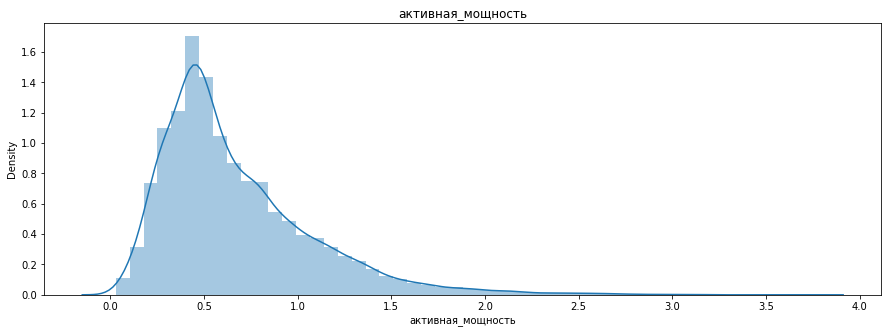

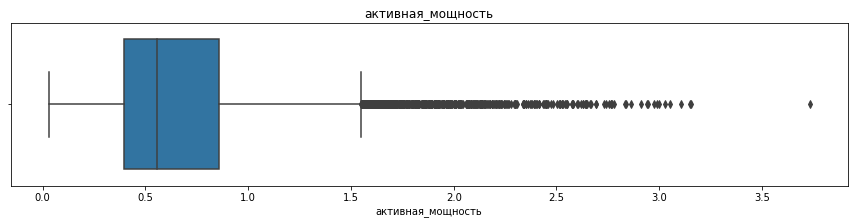

In [8]:
graphical(data_arc, 'активная_мощность')

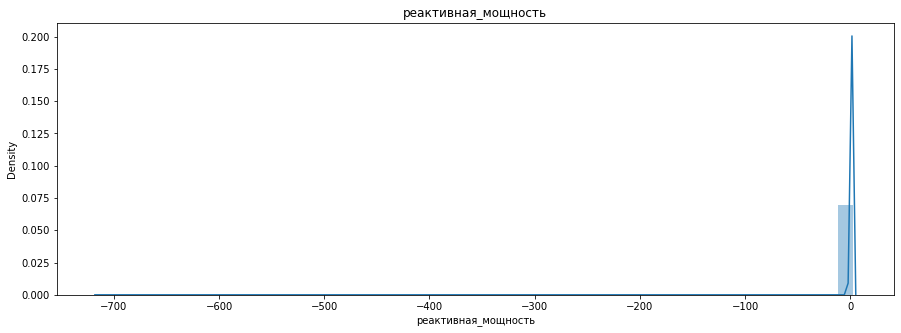

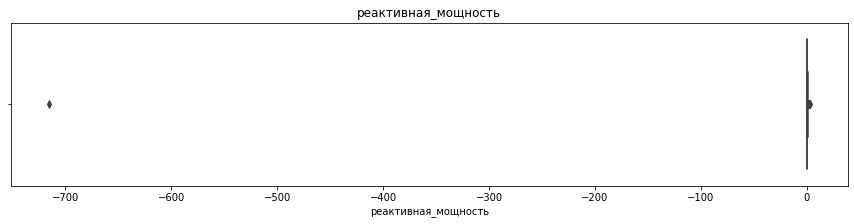

In [9]:
graphical(data_arc, 'реактивная_мощность')

Judging by the swing diagram, there is indeed a value much less than zero in the reactive power values.  Let's find it and the corresponding process data by the key value.

In [10]:
data_arc[data_arc['реактивная_мощность'] <= 0]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [11]:
data_arc[data_arc['key'] == 2116]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [12]:
data_arc = data_arc[data_arc['key'] != 2116]

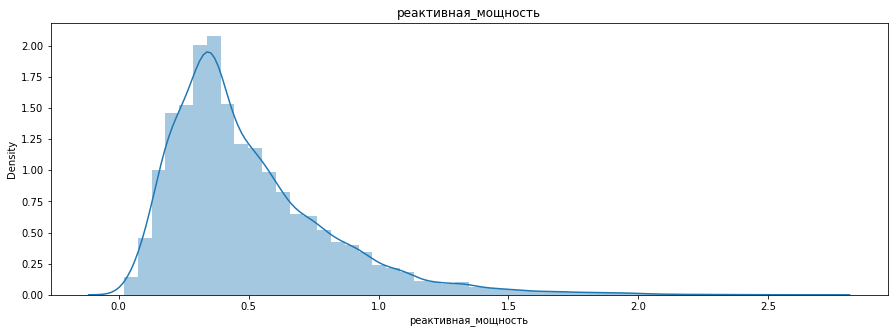

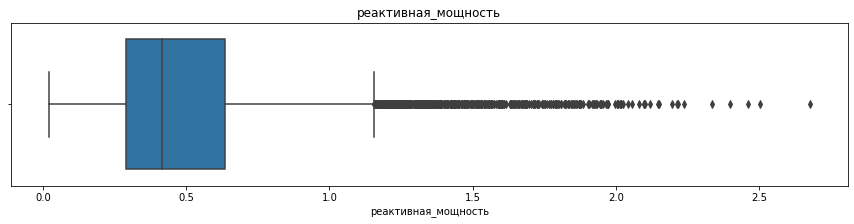

In [13]:
graphical(data_arc, 'реактивная_мощность')

The data for the unique process key == 2116 has been completely removed. The graphical reactive power data then returned to its "normal" state.

In [14]:
data_arc['полная_мощность'] = np.sqrt(data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2)

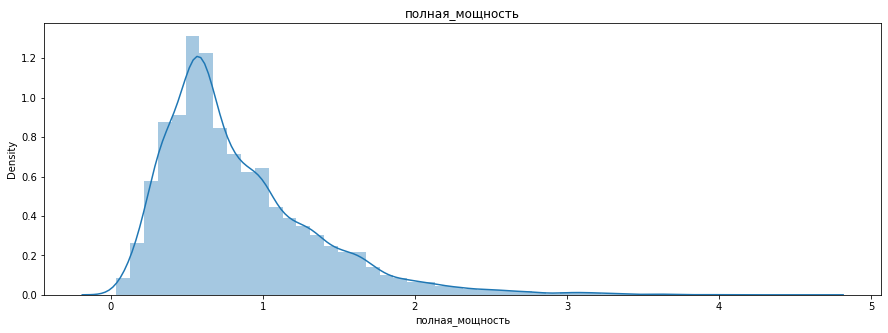

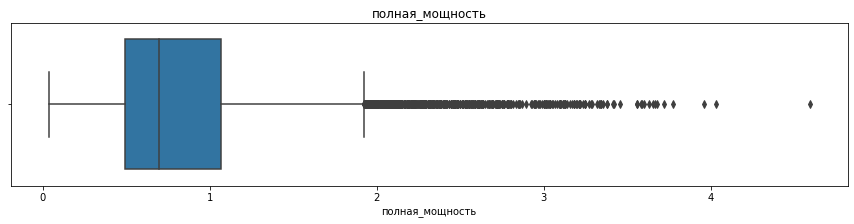

In [15]:
graphical(data_arc, 'полная_мощность')

To describe the total energy spent on one process, a column with information on apparent power is created, which is defined as the square root of the sum of the squares of active and reactive power. Graphical analysis of the new data showed the absence of any deviations.

In [16]:
data_arc['начало_нагрева_дугой'] = pd.to_datetime(data_arc['начало_нагрева_дугой'])
data_arc['конец_нагрева_дугой'] = pd.to_datetime(data_arc['конец_нагрева_дугой'])

Additionally, we convert the data type of the start and end time of arc heating.

For further modeling, we group the data for individual unique processes with the formation of a separate table.

In [17]:
data_arc_final = data_arc.groupby('key')['активная_мощность'].sum().reset_index()
data_arc_final.columns=['key', 'активная_мощность']
data_arc_final['реактивная_мощность'] = data_arc.groupby('key')['реактивная_мощность'].sum().reset_index(drop=True)
data_arc_final['полная_мощность'] = data_arc.groupby('key')['полная_мощность'].sum().reset_index(drop=True)
data_arc_final.head(20)

,key,активная_мощность,реактивная_мощность,полная_мощность
0,1,4.878147,3.183241,5.826395
1,2,3.052598,1.998112,3.649216
2,3,2.525882,1.599076,2.989534
3,4,3.209250,2.060298,3.814962
4,5,3.347173,2.252643,4.035758
5,6,3.955108,2.689175,4.786837
6,7,2.547375,1.561295,2.987777
7,8,3.762755,2.680698,4.627389
8,9,2.081951,1.478671,2.555348
9,10,2.923622,2.496116,3.851739


### Bulk material feed data (volume)

In [18]:
columns(data_bulk)

At the very beginning, we will rename the columns.

In [19]:
initial(data_bulk)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Первые строки датафрейма


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Статистические данные датафрейма


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.0,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.0,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.0,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.0,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.0,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.0,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.0,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


Количество пропущенных значений по столбцам


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

Количество дубликатов в датафрейме


0

There are a large number of gaps in the data, which we will replace with zero, since it is likely that the gap means that nothing was added at this stage.

In [20]:
data_bulk = data_bulk.fillna(0)

Let's move on to visualization and graphical analysis.

Text(0.5, 1.05, 'Гистограмма частот по столбцам')

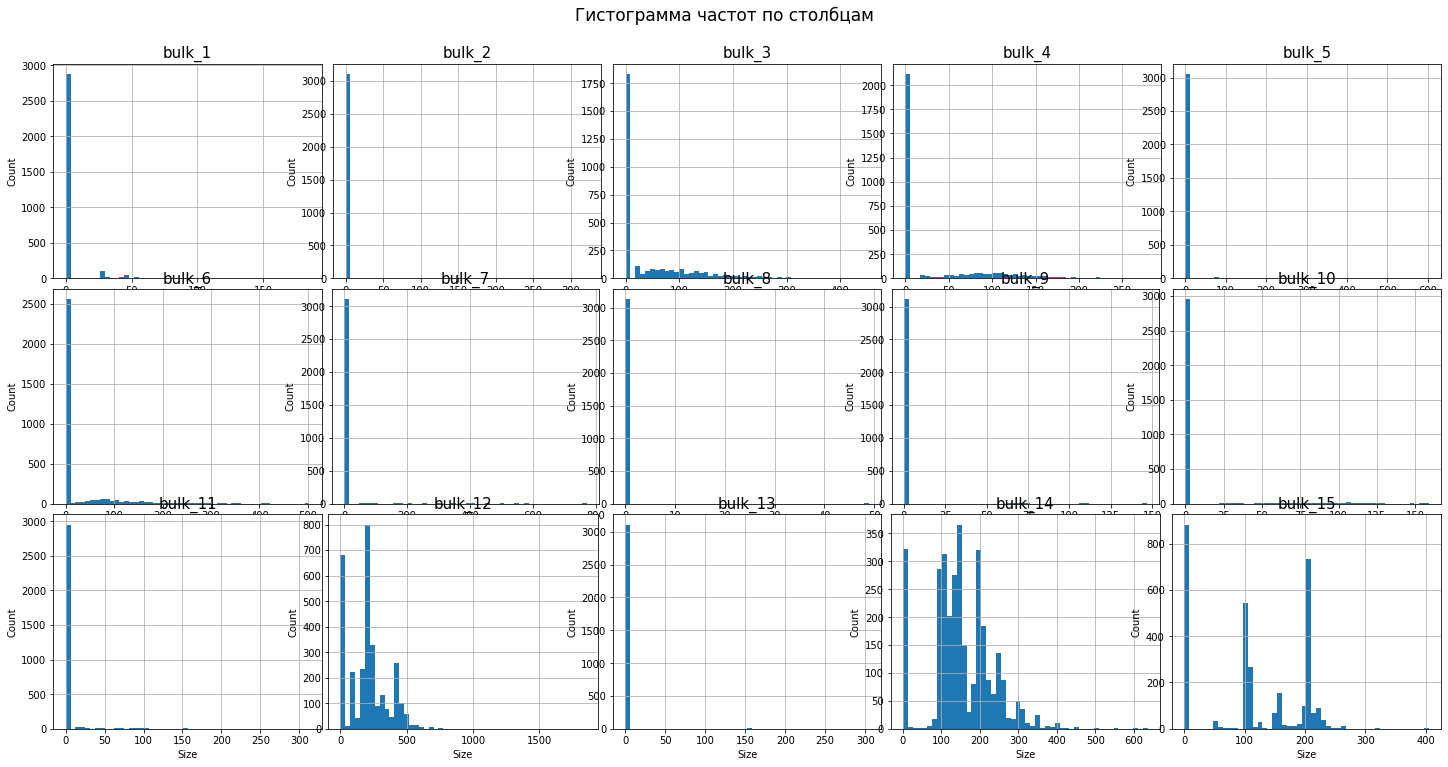

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
i = 0
for col in data_bulk.columns[1:]:
    i += 1
    ax = plt.subplot(3, 5, i)
    data_bulk[col].hist(bins=50, ax=ax)
    ax.set_title(col, fontsize=15);
    ax.set(xlabel="Size", ylabel="Count")
fig.suptitle("Гистограмма частот по столбцам", fontsize=17, y=1.05)

Visually, according to the constructed histograms, there is a large and prevailing number of zero values at each stage, which indicates that in most cases bulk materials are not added.  At the same time, in the last stages 12, 14 and 15, a large number of values greater than zero are observed, which most likely indicates active work on adding alloying elements in case the necessary steel characteristics are not obtained at the end of the process, and in the initial stages there is more emphasis on adjusting the temperature and adding wire  materials.

### Bulk materials feeding data (time)

In [22]:
columns(data_bulk_time)

At the very beginning, we will rename the columns.

In [23]:
initial(data_bulk_time)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Первые строки датафрейма


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


Статистические данные датафрейма


,key
count,3129.00
mean,1624.38
std,933.34
min,1.00
25%,816.00
50%,1622.00
75%,2431.00
max,3241.00


Количество пропущенных значений по столбцам


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

Количество дубликатов в датафрейме


0

Let's convert time data to datetime format.

In [24]:
for column in data_bulk_time.columns[1:]:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column])

### Alloy gas purge data

In [25]:
columns(data_gas)

At the very beginning, we will rename the columns.

In [26]:
initial(data_gas)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Первые строки датафрейма


,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Статистические данные датафрейма


,key,газ_1
count,3239.00,3239.00
mean,1621.86,11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,1622.00,9.84
75%,2431.50,13.77
max,3241.00,78.00


Количество пропущенных значений по столбцам


key      0
газ_1    0
dtype: int64

Количество дубликатов в датафрейме


0

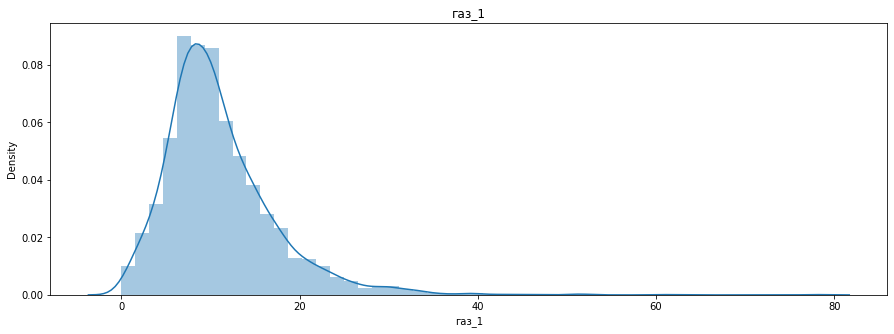

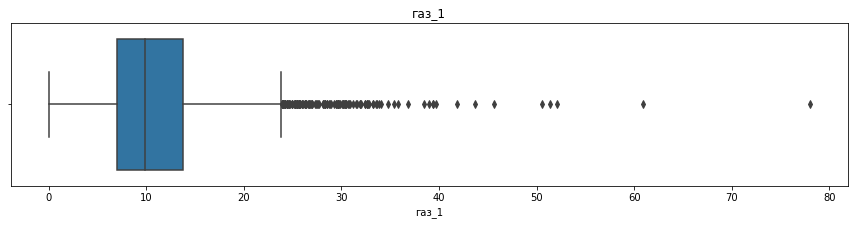

In [27]:
graphical(data_gas, 'газ_1')

Graphical data visually do not have deviations.

### Temperature measurement results

In [28]:
columns(data_temp)

At the very beginning, we will rename the columns.

In [29]:
initial(data_temp)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   время_замера  15907 non-null  object 
 2   температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

Первые строки датафрейма


,key,время_замера,температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Статистические данные датафрейма


,key,температура
count,15907.00,13006.00
mean,1607.88,1591.84
std,942.21,21.38
min,1.00,1191.00
25%,790.00,1581.00
50%,1618.00,1591.00
75%,2427.00,1601.00
max,3241.00,1705.00


Количество пропущенных значений по столбцам


key                0
время_замера       0
температура     2901
dtype: int64

Количество дубликатов в датафрейме


0

There are no duplicates in the data, but there are a large number of gaps in the target temperature attribute. They must be removed.

In [30]:
data_temp['время_замера'] = pd.to_datetime(data_temp['время_замера'])

In [31]:
data_temp = data_temp.dropna()

The time data has been converted to datetime format and the gaps have been removed.

In [32]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   время_замера  13006 non-null  datetime64[ns]
 2   температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


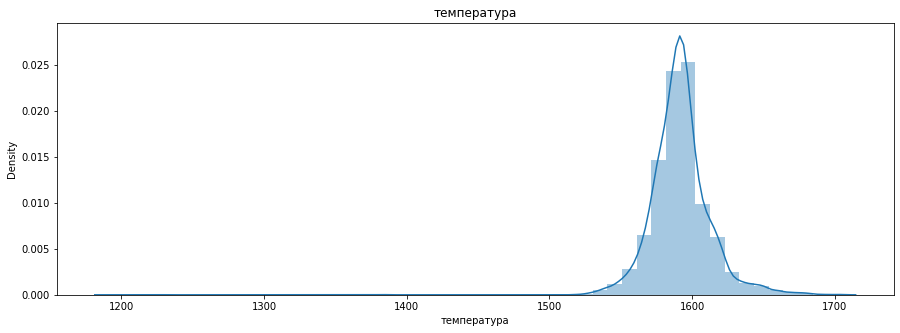

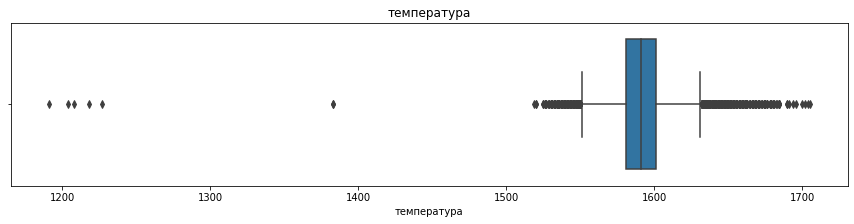

In [33]:
graphical(data_temp, 'температура')

Data for temperatures below 1400 looks like clear outliers, given also that the temperature of the metal is about 1400 degrees.

In [34]:
data_temp[data_temp['температура'] < 1400]

,key,время_замера,температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [35]:
key_temp = list(data_temp[data_temp['температура'] < 1400]['key'])
key_temp

[867, 1214, 1619, 1818, 1818, 2052, 2561]

In [36]:
data_temp = data_temp.query('key not in @key_temp')

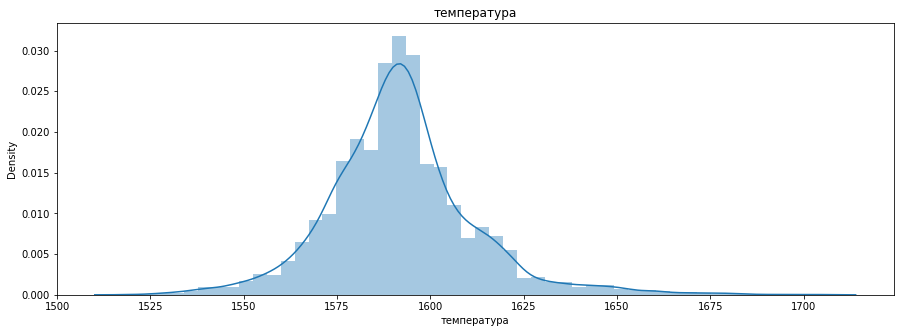

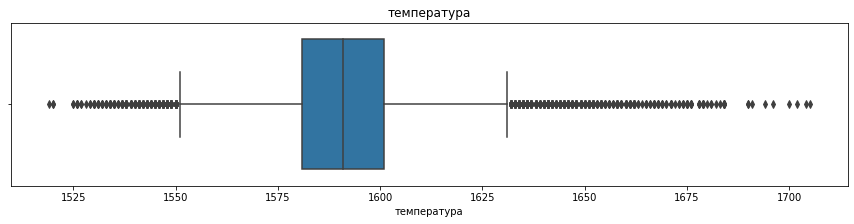

In [37]:
graphical(data_temp, 'температура')

Process data with a key related to detected outliers has been completely removed.  Graphical data after that visually have no deviations.

For further modeling, we will conduct an analysis to highlight the initial and final temperatures, as well as the number of temperature measurements.

In [38]:
data_first_temp = pd.merge(data_temp.groupby('key')['время_замера'].agg('min'), data_temp, 
                         how='left', on='время_замера')
data_last_temp = pd.merge(data_temp.groupby('key')['время_замера'].agg('max'), data_temp, 
                        how='left', on='время_замера')
data_count_temp = data_temp.drop(['время_замера'], axis=1).groupby('key').agg('count')
data_temp_final = pd.merge(data_first_temp[['key','температура']], data_last_temp[['key','температура']], 
                         how='outer', on='key')
data_temp_final = pd.merge(data_temp_final, data_count_temp, how='outer', on='key')
data_temp_final.rename(columns={'температура_x': 'начальная_температура', 'температура_y': 'конечная_температура', 
                              'температура': 'количество_замеров'}, inplace=True)
data_temp_final

,key,начальная_температура,конечная_температура,количество_замеров
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2
...,...,...,...,...
3205,3237,1569.0,1569.0,1
3206,3238,1584.0,1584.0,1
3207,3239,1598.0,1598.0,1
3208,3240,1617.0,1617.0,1


With this data output, intermediate temperature measurements are not saved, which is what we need for the regression problem. Processes with one measurement must be deleted as they do not contain information about the two required temperatures.

In [39]:
data_temp_final = data_temp_final[data_temp_final['количество_замеров'] > 1]
data_temp_final = data_temp_final.drop(['количество_замеров'], axis=1)
data_temp_final

,key,начальная_температура,конечная_температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2467,2495,1570.0,1591.0
2468,2496,1554.0,1591.0
2469,2497,1571.0,1589.0
2470,2498,1591.0,1594.0


The resulting dataframe will be used later to combine data.

### Wire materials data (volume)

In [40]:
columns(data_wire)

At the very beginning, we will rename the columns.

In [41]:
initial(data_wire)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Первые строки датафрейма


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Статистические данные датафрейма


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


Количество пропущенных значений по столбцам


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

Количество дубликатов в датафрейме


0

There are a large number of gaps in the data, which we will replace with zero, since it is likely that the gap means that nothing was added at this stage.

In [42]:
data_wire = data_wire.fillna(0)

Let's move on to visualization and graphical analysis.

Text(0.5, 1.05, 'Гистограмма частот по столбцам')

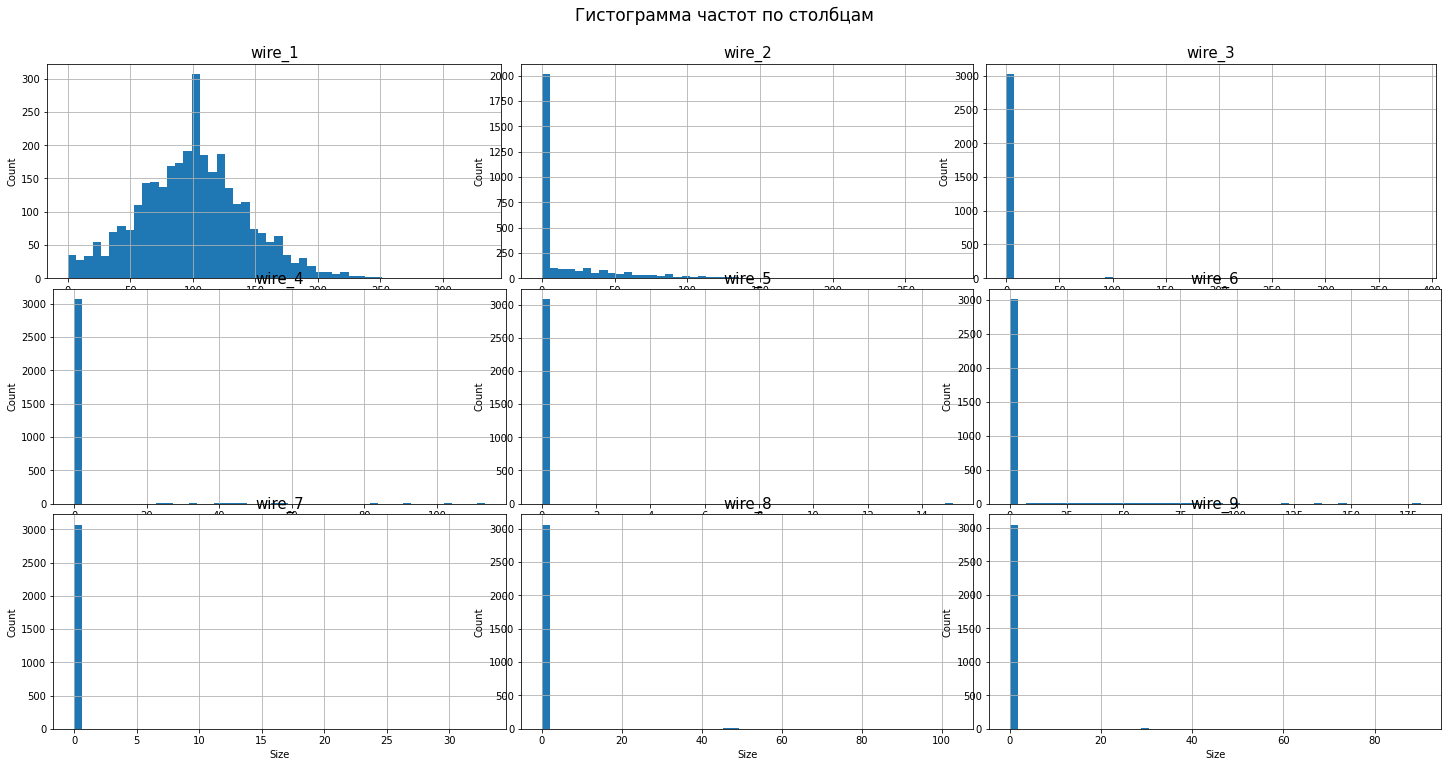

In [43]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
i = 0
for col in data_wire.columns[1:]:
    i += 1
    ax = plt.subplot(3, 3, i)
    data_wire[col].hist(bins=50, ax=ax)
    ax.set_title(col, fontsize=15);
    ax.set(xlabel="Size", ylabel="Count")
fig.suptitle("Гистограмма частот по столбцам", fontsize=17, y=1.05)

Here, our assumption was confirmed, which was put forward earlier when analyzing similar histograms for bulk materials, that at the initial stages of the process, in order to achieve the required chemical composition, work is actually carried out only with wire materials (as is observed especially on the wire_1 histogram), and at the last stages only bulk materials are used.

### Wire material data (time)

In [44]:
columns(data_wire_time)

At the very beginning, we will rename the columns.

In [45]:
initial(data_wire_time)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Первые строки датафрейма


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Статистические данные датафрейма


,key
count,3081.00
mean,1623.43
std,933.00
min,1.00
25%,823.00
50%,1619.00
75%,2434.00
max,3241.00


Количество пропущенных значений по столбцам


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

Количество дубликатов в датафрейме


0

Let's convert time data to datetime format.

In [46]:
for column in data_wire_time.columns[1:]:
    data_wire_time[column] = pd.to_datetime(data_wire_time[column])

### Data aggregation

We will sequentially merge the dataframes, starting with a specially formed table with the initial and final temperatures.

In [47]:
data_final = data_temp_final.merge(data_arc_final, how='inner', on=['key'])
data_final.head(20)

,key,начальная_температура,конечная_температура,активная_мощность,реактивная_мощность,полная_мощность
0,1,1571.0,1613.0,4.878147,3.183241,5.826395
1,2,1581.0,1602.0,3.052598,1.998112,3.649216
2,3,1596.0,1599.0,2.525882,1.599076,2.989534
3,4,1601.0,1625.0,3.209250,2.060298,3.814962
4,5,1576.0,1602.0,3.347173,2.252643,4.035758
5,6,1543.0,1596.0,3.955108,2.689175,4.786837
6,7,1586.0,1599.0,2.547375,1.561295,2.987777
7,8,1577.0,1598.0,3.762755,2.680698,4.627389
8,9,1587.0,1592.0,2.081951,1.478671,2.555348
9,10,1574.0,1593.0,2.923622,2.496116,3.851739


In [48]:
data_final = data_final.merge(data_gas, on=['key'], how='inner')
data_final.head(20)

,key,начальная_температура,конечная_температура,активная_мощность,реактивная_мощность,полная_мощность,газ_1
0,1,1571.0,1613.0,4.878147,3.183241,5.826395,29.749986
1,2,1581.0,1602.0,3.052598,1.998112,3.649216,12.555561
2,3,1596.0,1599.0,2.525882,1.599076,2.989534,28.554793
3,4,1601.0,1625.0,3.209250,2.060298,3.814962,18.841219
4,5,1576.0,1602.0,3.347173,2.252643,4.035758,5.413692
5,6,1543.0,1596.0,3.955108,2.689175,4.786837,11.273392
6,7,1586.0,1599.0,2.547375,1.561295,2.987777,9.836267
7,8,1577.0,1598.0,3.762755,2.680698,4.627389,15.171553
8,9,1587.0,1592.0,2.081951,1.478671,2.555348,8.216623
9,10,1574.0,1593.0,2.923622,2.496116,3.851739,6.529891


In [49]:
data_final = data_final.merge(data_bulk, how='inner', on=['key'])
data_final.head(20)

,key,начальная_температура,конечная_температура,активная_мощность,реактивная_мощность,полная_мощность,газ_1,bulk_1,bulk_2,bulk_3,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,1571.0,1613.0,4.878147,3.183241,5.826395,29.749986,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1581.0,1602.0,3.052598,1.998112,3.649216,12.555561,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1596.0,1599.0,2.525882,1.599076,2.989534,28.554793,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1601.0,1625.0,3.209250,2.060298,3.814962,18.841219,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1576.0,1602.0,3.347173,2.252643,4.035758,5.413692,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
5,6,1543.0,1596.0,3.955108,2.689175,4.786837,11.273392,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0
6,7,1586.0,1599.0,2.547375,1.561295,2.987777,9.836267,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0
7,8,1577.0,1598.0,3.762755,2.680698,4.627389,15.171553,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0
8,9,1587.0,1592.0,2.081951,1.478671,2.555348,8.216623,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0
9,10,1574.0,1593.0,2.923622,2.496116,3.851739,6.529891,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0


In [50]:
data_final = data_final.merge(data_wire, how='inner', on=['key'])
data_final.head(20)

,key,начальная_температура,конечная_температура,активная_мощность,реактивная_мощность,полная_мощность,газ_1,bulk_1,bulk_2,bulk_3,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,4.878147,3.183241,5.826395,29.749986,0.0,0.0,0.0,...,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,3.052598,1.998112,3.649216,12.555561,0.0,0.0,0.0,...,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,2.525882,1.599076,2.989534,28.554793,0.0,0.0,0.0,...,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,3.209250,2.060298,3.814962,18.841219,0.0,0.0,0.0,...,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,3.347173,2.252643,4.035758,5.413692,0.0,0.0,0.0,...,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,1543.0,1596.0,3.955108,2.689175,4.786837,11.273392,0.0,0.0,0.0,...,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,1586.0,1599.0,2.547375,1.561295,2.987777,9.836267,0.0,0.0,0.0,...,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,1577.0,1598.0,3.762755,2.680698,4.627389,15.171553,0.0,0.0,0.0,...,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,1587.0,1592.0,2.081951,1.478671,2.555348,8.216623,0.0,0.0,0.0,...,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,1574.0,1593.0,2.923622,2.496116,3.851739,6.529891,0.0,0.0,0.0,...,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2324 non-null   int64  
 1   начальная_температура  2324 non-null   float64
 2   конечная_температура   2324 non-null   float64
 3   активная_мощность      2324 non-null   float64
 4   реактивная_мощность    2324 non-null   float64
 5   полная_мощность        2324 non-null   float64
 6   газ_1                  2324 non-null   float64
 7   bulk_1                 2324 non-null   float64
 8   bulk_2                 2324 non-null   float64
 9   bulk_3                 2324 non-null   float64
 10  bulk_4                 2324 non-null   float64
 11  bulk_5                 2324 non-null   float64
 12  bulk_6                 2324 non-null   float64
 13  bulk_7                 2324 non-null   float64
 14  bulk_8                 2324 non-null   float64
 15  bulk

The received dataframe is planned for use in further work.

## Preparing Data for Machine Learning

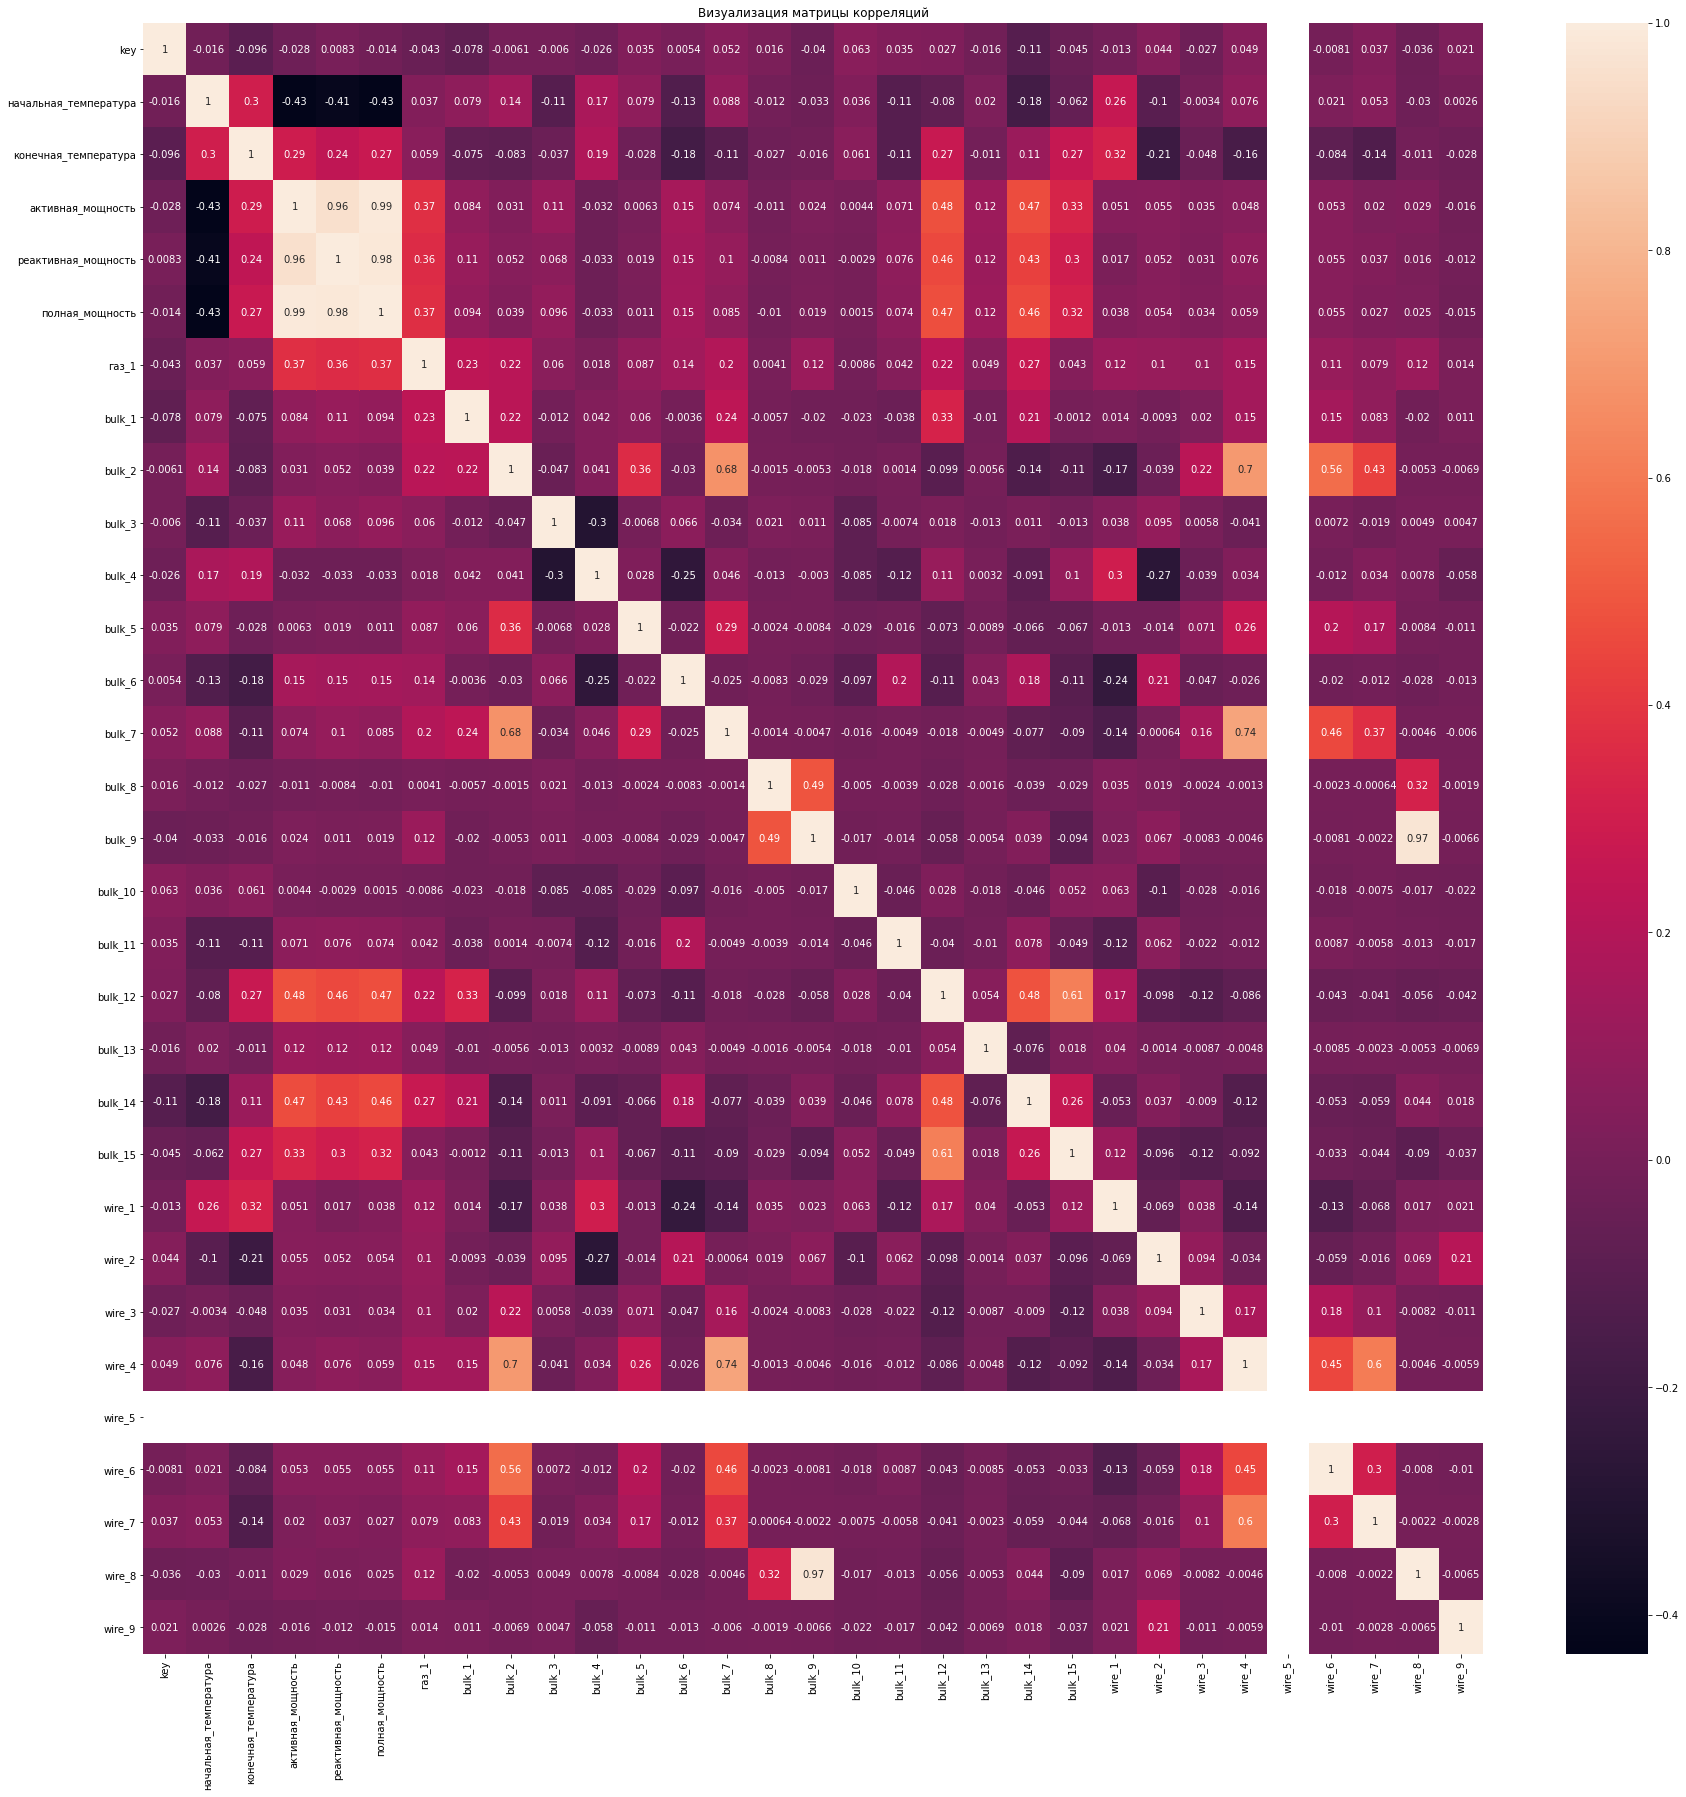

In [52]:
plt.figure(figsize=(30,30))
sns.heatmap(data_final.corr(), annot=True)
plt.title('Визуализация матрицы корреляций')
plt.show()

There is practically no significant correlation between the signs (more than 0.9).  It is between the capacities and the total power determined by us.  In this situation, it was decided to remove the capacity except for the full one.  There is also a significant correlation between bulk_9 and wire_8, we will also remove them to eliminate the influence of this factor on the result of the models.

In [53]:
data_final['wire_5'].unique()

array([0.])

In [54]:
data_final.drop(columns=['key', 'активная_мощность', 'реактивная_мощность', 
                         'bulk_9', 'wire_5', 'wire_8'], inplace=True)

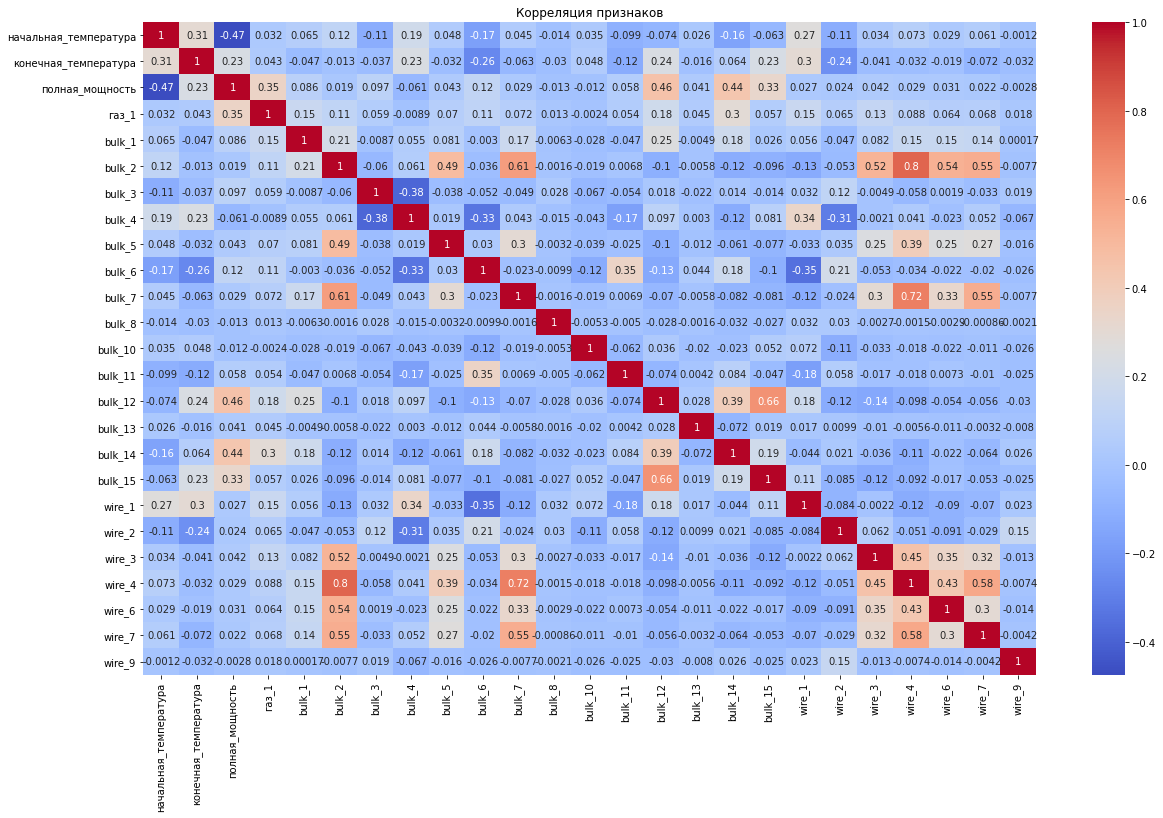

In [55]:
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(data_final.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

Since, as noted on the visualization and verified by the output of unique values, the wire_5 feature consists entirely of zeros (no additives were added in any process at this stage), this feature was completely removed. The key column was also removed, as it is no longer needed for building the model.

In [57]:
features = data_final.drop('конечная_температура', axis=1)
target = data_final['конечная_температура']

In [58]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=3102022)

In [59]:
print(f'Размерность features_train: {features_train.shape}, Размерность target_train: {target_train.shape}') 
print(f'Размерность features_test: {features_test.shape}, Размерность target_test: {target_test.shape}')

Размерность features_train: (1743, 24), Размерность target_train: (1743,)
Размерность features_test: (581, 24), Размерность target_test: (581,)


In [60]:
1743+581

2324

Let's prepare the data by dividing it into features and a target feature. To split the data into two samples (training and test), the train_test_split method was used. The sampling ratio was 3:1 or 75%:25%. Dimension check completed successfully.

In [61]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

We scaled numerical data using the Standard Scaler.

## Finding the Best Machine Learning Model

In [62]:
models_scores = pd.DataFrame(columns = ['model', 'mae'])

Let's create a table of the results of the selection of the best models and proceed to the selection of the parameters of various models.

In [63]:
%%time
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
prediction = dummy.predict(features_test)
score_dummy = mean_absolute_error(target_test, prediction)

print(f'MAE для DummyRegressor: {score_dummy}')

models_scores = models_scores.append({'model': 'DummyRegressor', 'mae': score_dummy}, ignore_index=True)

MAE для DummyRegressor: 7.773338744700973
CPU times: user 0 ns, sys: 5.35 ms, total: 5.35 ms
Wall time: 4.27 ms


The dummy model shows very good results in terms of speed, but with a poor MAE metric.

In [67]:
%%time
lr = LinearRegression()
scores = cross_val_score(lr, features_train, target_train, scoring='neg_mean_absolute_error')
score_lr = -np.mean(scores)

print(f'MAE для LinearRegression: {score_lr}')

models_scores = models_scores.append({'model': 'LinearRegression', 'mae': score_lr}, ignore_index=True)

MAE для LinearRegression: 6.307638579435917
CPU times: user 46.4 ms, sys: 51.6 ms, total: 97.9 ms
Wall time: 19.3 ms


In [65]:
scores

array([-6.32989924, -6.51980486, -6.2145649 , -6.55614047, -5.91778342])

Linear regression also performed well in terms of speed, but very poor in terms of the MAE metric.

In [ ]:
%%time
LGBM = LGBMRegressor(verbose=-1, random_state=3102022)

parameters = {'max_depth': np.arange(1, 50, 5),
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': np.arange(1, 50, 5)}

LGBM_grid = GridSearchCV(LGBM, param_grid=parameters, scoring='neg_mean_absolute_error', 
                         n_jobs=-1, cv=5, verbose=1)
LGBM_grid.fit(features_train, target_train)

print(f'Лучшие параметры модели LGBMRegressor: {LGBM_grid.best_params_}')

score_LGBM = abs(LGBM_grid.best_score_)

print(f'Лучший MAE для LGBMRegressor: {score_LGBM}')

models_scores = models_scores.append({'model' : 'LGBMRegressor', 'mae' : score_LGBM}, ignore_index=True)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


LGBMRegressor showed a normal result in terms of speed and a very good result, close to the ideal values specified by the Customer, in terms of MAE.

In [67]:
%%time
CB = CatBoostRegressor(random_state=3102022)

parameters = {'max_depth': np.arange(1, 10, 1),
              'n_estimators': np.arange(500, 1000, 100)}

CB_grid = GridSearchCV(CB, param_grid=parameters, scoring='neg_mean_absolute_error', 
                       n_jobs=-1, cv=5, verbose=1)
CB_grid.fit(features_train, target_train, verbose=100)

print(f'Лучшие параметры модели CatBoostRegressor: {CB_grid.best_params_}')

score_CB = abs(CB_grid.best_score_)

print(f'Лучший MAE для CatBoostRegressor: {score_CB}')

models_scores = models_scores.append({'model' : 'CatBoostRegressor', 'mae' : score_CB}, ignore_index=True)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Learning rate set to 0.075807
0:	learn: 11.2550890	total: 55.8ms	remaining: 27.8s
100:	learn: 9.1297650	total: 82.5ms	remaining: 326ms
200:	learn: 8.3696958	total: 109ms	remaining: 162ms
300:	learn: 8.0546247	total: 135ms	remaining: 89.4ms
400:	learn: 7.8325464	total: 162ms	remaining: 40ms
499:	learn: 7.6813070	total: 190ms	remaining: 0us
Learning rate set to 0.065364
0:	learn: 11.2842590	total: 374us	remaining: 225ms
100:	learn: 9.2043018	total: 27.9ms	remaining: 138ms
200:	learn: 8.3979643	total: 55.1ms	remaining: 109ms
300:	learn: 8.0563217	total: 83.2ms	remaining: 82.6ms
400:	learn: 7.8750121	total: 110ms	remaining: 54.6ms
500:	learn: 7.7519022	total: 137ms	remaining: 27.1ms
599:	learn: 7.6673720	total: 165ms	remaining: 0us
Learning rate set to 0.065371
0:	learn: 11.6176453	total: 327us	remaining: 196ms
100:	learn: 9.3176113	total: 29ms	remaining: 143ms
200:	learn: 8.4455190	total: 57.4ms	remaining: 114ms
300:	learn: 8.0

CatBoostRegressor, as usual, according to past experience with this model, showed the slowest speed, but the best result of all the models used in terms of the MAE metric.

In [68]:
models_scores

,model,mae
0,DummyRegressor,7.773339
1,LinearRegression,10.568174
2,LGBMRegressor,6.096387
3,CatBoostRegressor,6.006960


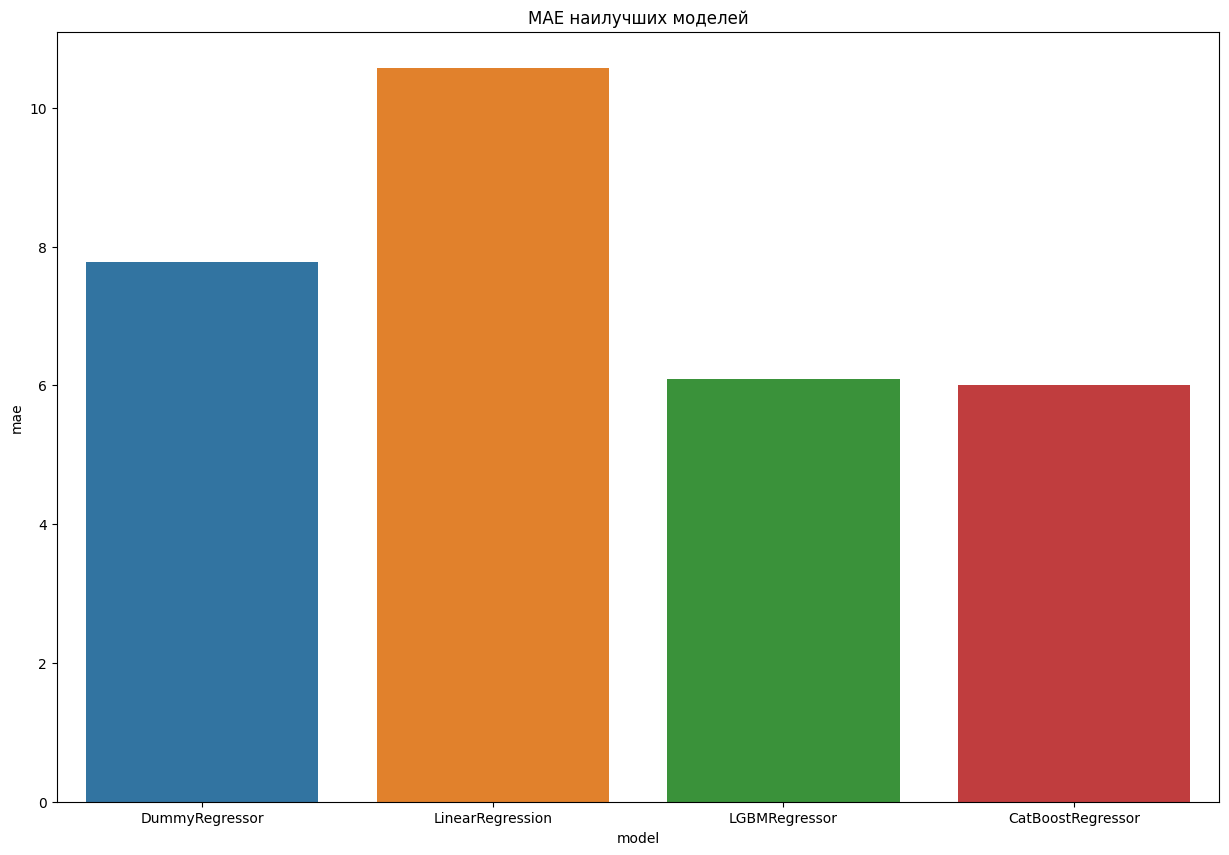

In [69]:
plt.figure(figsize=(15,10))
sns.barplot(x=models_scores['model'],y=models_scores['mae'])
plt.title('MAE наилучших моделей')
plt.show()

### Testing the best model

After the analysis, the CatBoostRegressor model has the best result, which will be accepted for final testing.

In [70]:
print(f'Лучшие параметры модели CatBoostRegressor: {CB_grid.best_params_}')

score_CB = abs(CB_grid.best_score_)

print(f'Лучший MAE для CatBoostRegressor: {score_CB}')

Лучшие параметры модели CatBoostRegressor: {'max_depth': 5, 'n_estimators': 800}
Лучший MAE для CatBoostRegressor: 6.006960406979713


In [71]:
prediction_test = CB_grid.best_estimator_.predict(features_test)

print(f'MAE наилучшей модели на тестовой выборке: {mean_absolute_error(target_test, prediction_test)}')

MAE наилучшей модели на тестовой выборке: 5.825306621599304


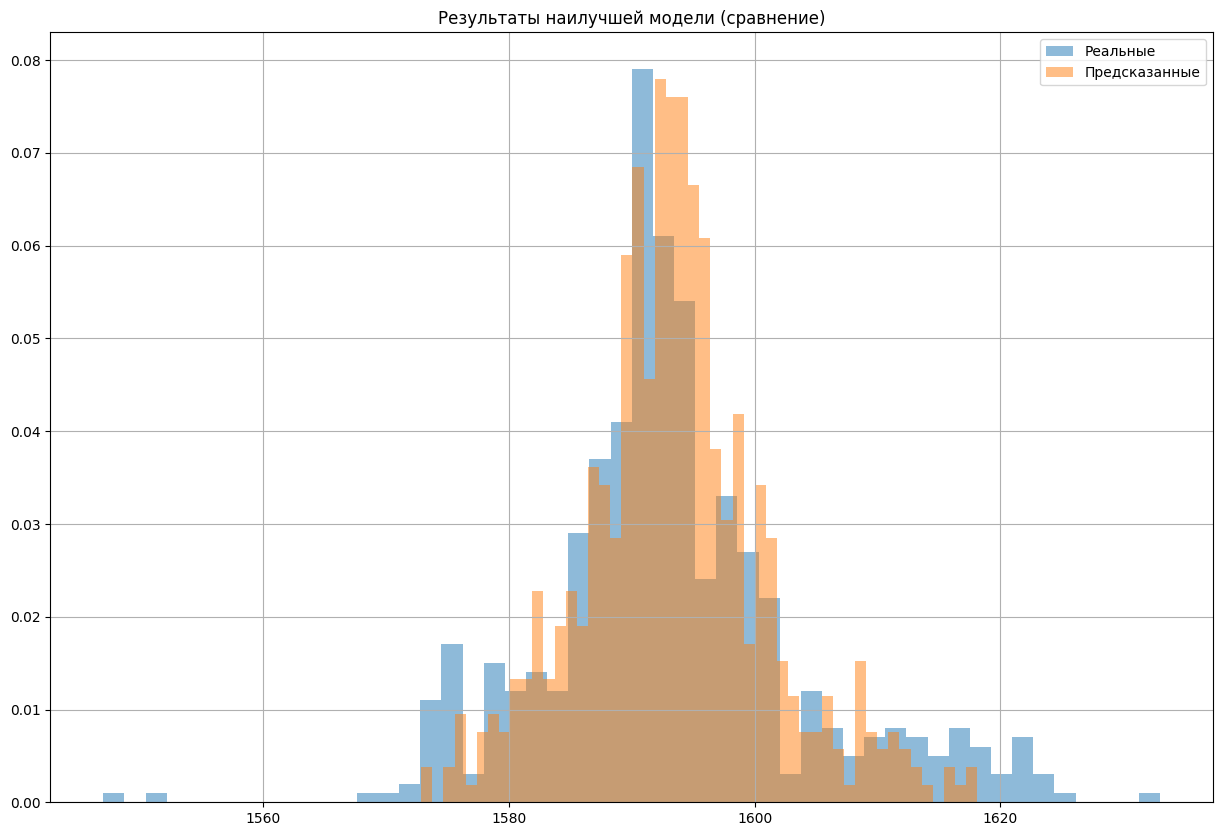

In [72]:
plt.figure(figsize=(15, 10))
target_test.hist(bins = 50, alpha=0.5, density=True, label='Реальные')
pd.Series(prediction_test).hist(bins = 50, alpha=0.5, density=True, label='Предсказанные')
plt.title('Результаты наилучшей модели (сравнение)')
plt.legend()
plt.show()

The results of comparing the performance of the best model and actual data are comparable.  The distributions are generally the same, but the prediction results have a smoother plot without less pronounced maxima and extreme values.

Text(0.5, 1.0, 'Важность признаков наилучшей модели')

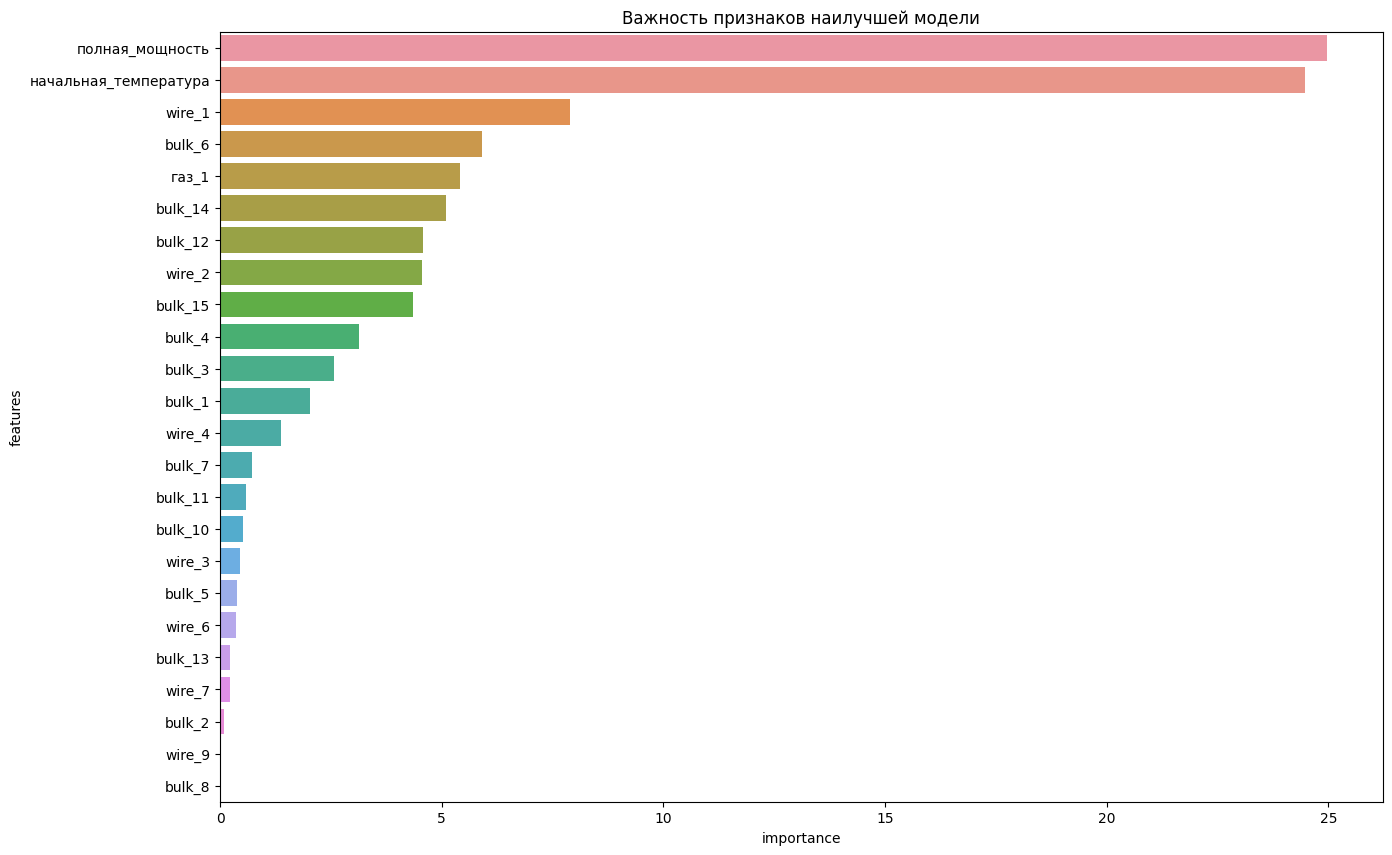

In [73]:
features_columns = features.columns
importance = CB_grid.best_estimator_.feature_importances_

feature_importances = pd.DataFrame({'features': features_columns, 'importance': importance})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(15, 10))
sns.barplot(feature_importances['importance'], feature_importances['features'])

plt.title('Важность признаков наилучшей модели')

As expected, the most important in the model by a significant margin are the total power and the initial temperature.  Further, to a lesser extent, there are, as we noted in the graphical analysis, data on wire materials at the initial stages and data on bulk materials at the final stages of the processes, as well as data on gas purge.  The remaining features are already of much lesser importance, which justifies, among other things, the possibility of their exclusion from the construction of the model and the potential exclusion or reduction of the amount of attention to them when controlling the technological process in production.

This CatBoostRegressor model with an MAE score of 5.8253 is recommended for use in steel temperature prediction.

## Decision Report

### Description of the problem being solved

In order to optimize production costs, the metallurgical plant Tak Temper Steel LLC decided to reduce electricity consumption at the stage of steel processing. It is necessary to build a model that predicts the steel temperature.

Below is a brief description of the workflow.

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus.

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks.

Based on the results of the preliminary analysis of the data provided, the following work plan was formed:

- Analysis of initial data
     - Data preprocessing
     - Graphical data analysis
     - Combining data into one dataframe
- Preparing data for machine learning
     - Splitting features into training and test sets
     - Conduct feature scaling
- Finding the best machine learning model
     - Selection of parameters of the best model using GridSearchCV and MAE metrics
     - Checking the best model on the test set

In accordance with the task, we sought to obtain the best model with a MAE metric ≤ 6.0.

### Solution Description

At the beginning of the work, data preprocessing was carried out for each data group.

- electrode data

There were no missing values or duplicates in the data, but there was a minimum negative value of reactive power that cannot be negative. The graphical analysis situation was checked and, as a result, the data on the unique process corresponding to the negative value were completely deleted.
- data on the supply of bulk materials (volume)

There were a lot of gaps in the data, which were replaced with zero, since it is likely that the gap means that nothing was added at this stage.
In the course of graphical analysis, visually, according to the constructed histograms, a large and prevailing number of zero values was observed at each stage, which indicates that in most cases bulk materials are not added.  At the same time, in the last stages 12, 14 and 15, a large number of values greater than zero were observed, which most likely indicates active work on adding alloying elements in case of failure to obtain the necessary characteristics of steel at the end of the process, and in the initial stages there is more emphasis on adjusting the temperature and adding wire  materials.
- data on the supply of bulk materials (time)

Numerical and graphical data on the time of supply of bulk materials had no deviations.
- data on alloy gas purge

Numerical and graphic data on gas purge on the right had no deviations.
- temperature measurement results

There were no duplicates in the data, but there were a large number of gaps in the temperature target.  They have been removed. Data for temperatures below 1400 are marked by clear outliers, also given that the temperature of the metal is about 1400 degrees. Data on unique processes related to the detected clear outliers have been completely removed.
- data on wire materials (volume)

There were a lot of gaps in the data, which were replaced with zero, since it is likely that the gap means that nothing was added at this stage.
In the course of the graphical analysis, our assumption, which was put forward earlier in the analysis of similar histograms for bulk materials, was confirmed, that at the initial stages of the process, in order to achieve the required chemical composition, work is actually carried out only with wire materials, especially at the very first stage, and at the last stages, only bulk materials are used.  materials.
- data on wire materials (time)

Numerical and graphical data on the time of supply of wire materials had no deviations.

During the analysis, additional features were formed to better describe the process and, accordingly, improve the search for models in the future.

So, to describe the total energy spent on one process, a column was created with information about the total power, which is defined as the square root of the sum of the squares of active and reactive power. Graphical analysis of the new data showed the absence of any deviations.

In the part of the temperature measurement data for further modeling, an analysis was carried out to separate the initial and final temperatures, as well as the number of temperature measurements.
In the generated general table, data on intermediate temperature measurements were not saved, which is necessary for the regression problem.  Single-measurement processes have been removed because they do not contain information about the two required temperatures.

In the future, for modeling purposes, the data were grouped into separate unique processes for each data group.
Consistently, the dataframes were combined, starting from a specially formed table with the initial and final temperatures.
The resulting common dataframe was used for further work on finding the best model.

Before the simulation, a multicollinearity test was carried out, during which there was practically no significant correlation between the features (more than 0.9).  It was present between the powers and the total power determined by us.  In this situation, it was decided to remove the capacities except for the full one.  There is also a significant correlation between bulk_9 and wire_8, they were also removed to exclude the influence of this factor on the result of the models.
Since, as noted on the visualization and verified by the output of unique values, the wire_5 feature consisted entirely of zeros (no additives were added in any process at this stage), this feature was completely removed. The key column was also removed, as it is no longer needed for building the model.

Data preparation was carried out with their division into features (features) and target feature (target). To split the data into two samples (training and test), the train_test_split method was used. The sampling ratio was 3:1 or 75%:25%. Dimension check completed successfully.
After that, separate scaling of numerical data was carried out using the Standard Scaler.

### Solution Results

During the search, parameters were selected and four models were tested: Dummy, linear regression, LGBMRegressor and CatBoostRegressor.  The selection of parameters was carried out using GridSearchCV.

The dummy model shows very good results in terms of speed, but with a poor MAE metric.

Linear regression also showed a good result in terms of speed, but still a bad and inappropriate result for us in terms of the MAE metric.

LGBMRegressor showed a normal result in terms of speed and a very good one, close to the given ideal values ​​of the result in MAE.

CatBoostRegressor, as usual, according to past experience with this model, showed the slowest performance, but the best result of all the used models in terms of MAE metric.

A summary table and graph of the results obtained are presented below.

In [74]:
models_scores

,model,mae
0,DummyRegressor,7.773339
1,LinearRegression,10.568174
2,LGBMRegressor,6.096387
3,CatBoostRegressor,6.006960


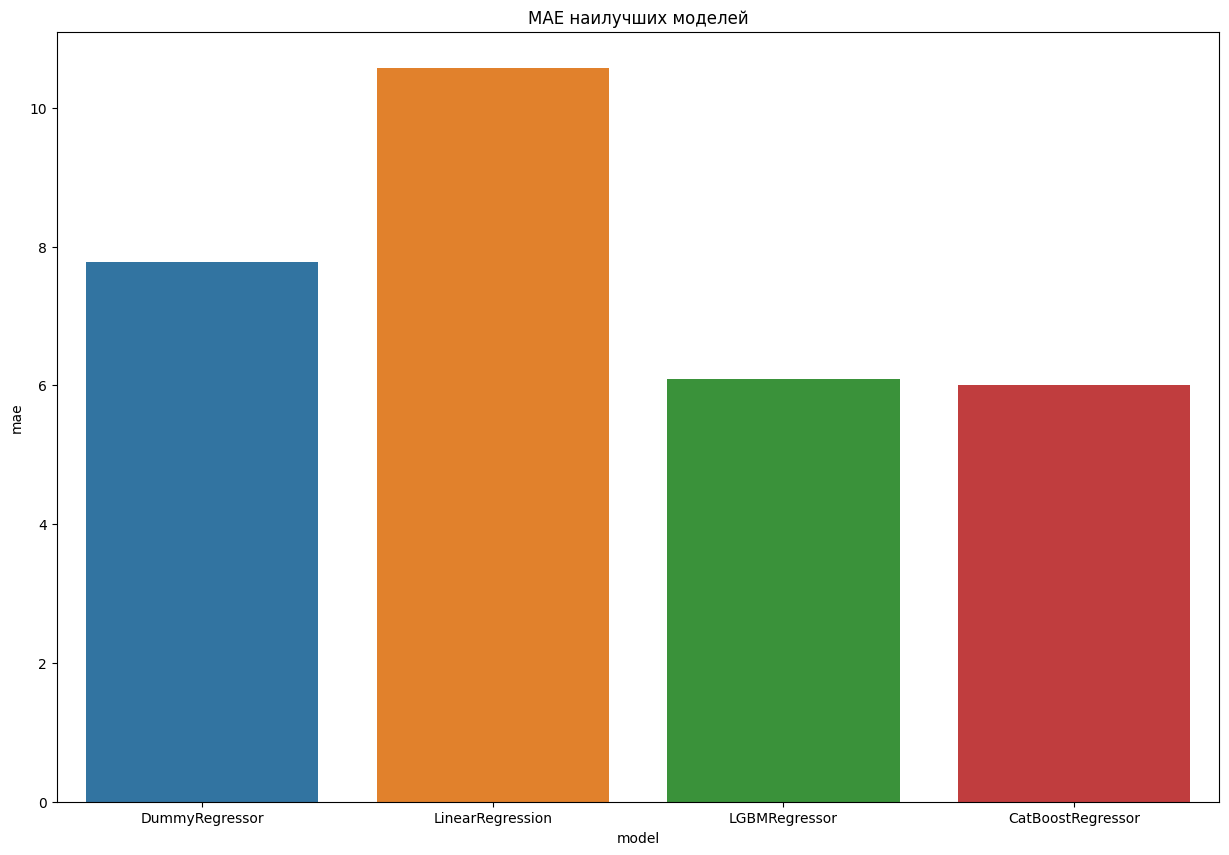

In [75]:
plt.figure(figsize=(15,10))
sns.barplot(x=models_scores['model'],y=models_scores['mae'])
plt.title('MAE наилучших моделей')
plt.show()

After the analysis, the best result was obtained by the CatBoostRegressor model, which was used for final testing with the following parameters.

In [76]:
print(f'Лучшие параметры модели CatBoostRegressor: {CB_grid.best_params_}')

Лучшие параметры модели CatBoostRegressor: {'max_depth': 5, 'n_estimators': 800}


Additionally, an analysis was carried out comparing the performance of the best model and actual data, which is presented in the graph below.

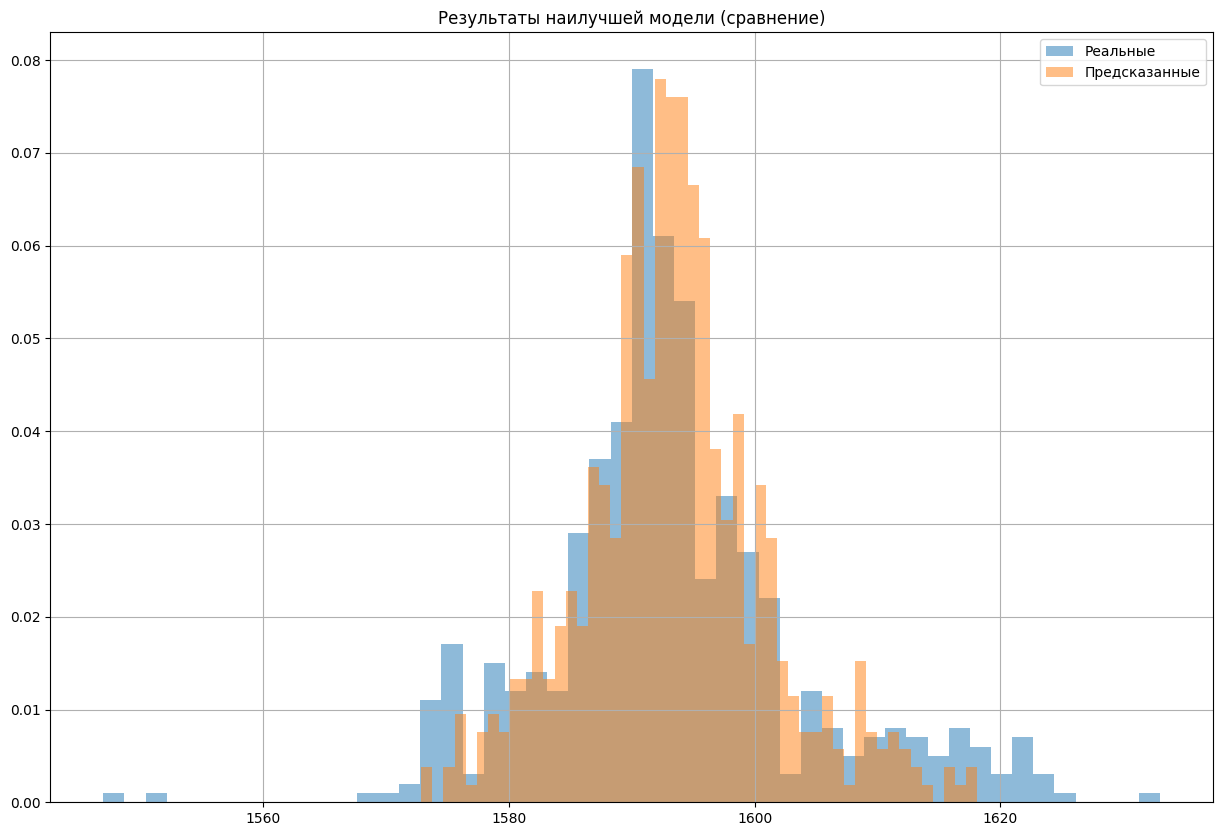

In [77]:
plt.figure(figsize=(15, 10))
target_test.hist(bins = 50, alpha=0.5, density=True, label='Реальные')
pd.Series(prediction_test).hist(bins = 50, alpha=0.5, density=True, label='Предсказанные')
plt.title('Результаты наилучшей модели (сравнение)')
plt.legend()
plt.show()

The comparison results are comparable. The distributions are generally the same, but the prediction results have a smoother plot without less pronounced maxima and extreme values.

A graph of the importance of the features of the model was also prepared, presented below.

Text(0.5, 1.0, 'Важность признаков наилучшей модели')

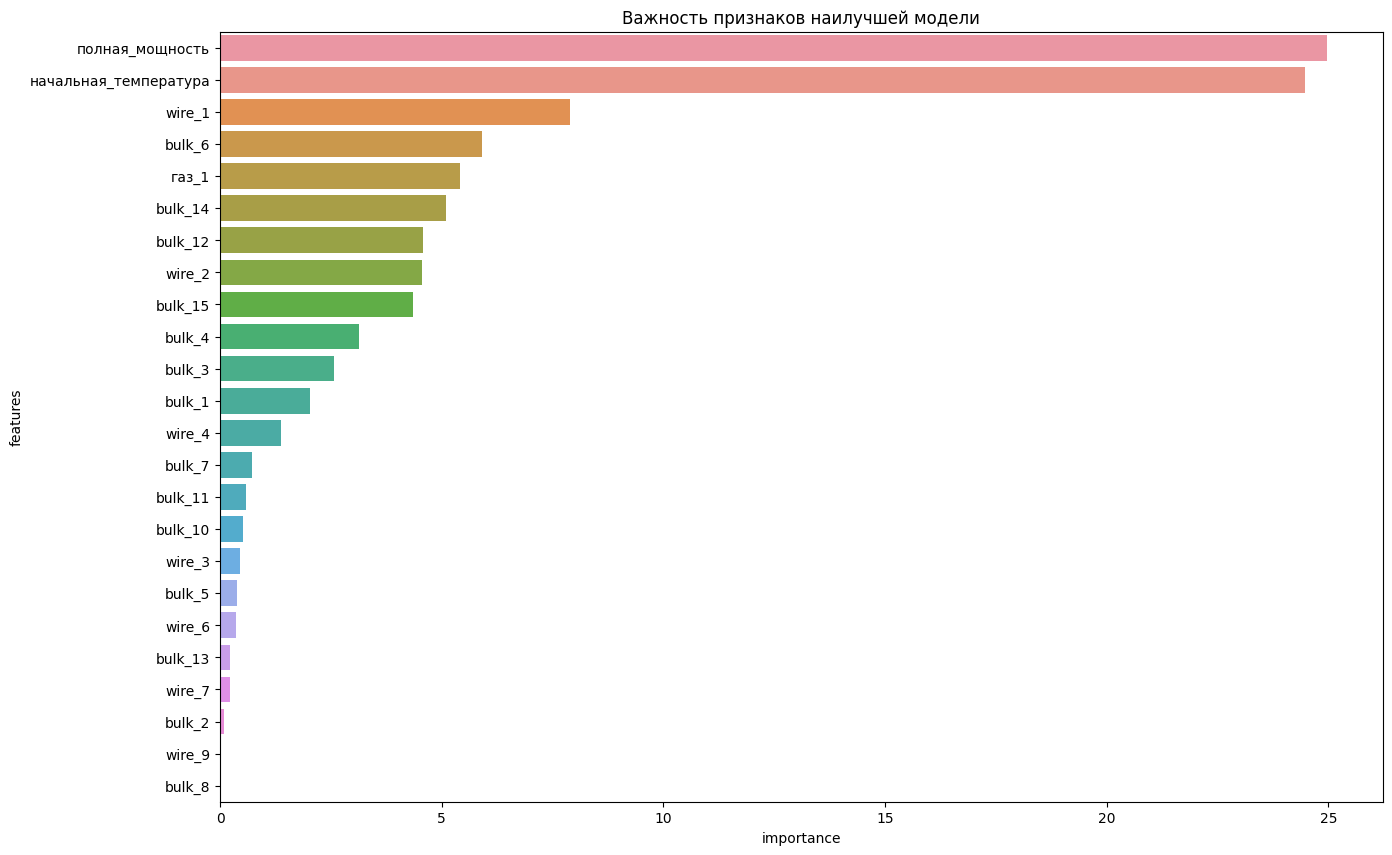

200:	learn: 6.5987601	total: 877ms	remaining: 3.05s
300:	learn: 5.9351374	total: 1.32s	remaining: 2.63s
400:	learn: 5.4540511	total: 1.64s	remaining: 2.04s
500:	learn: 5.0897434	total: 1.95s	remaining: 1.55s
600:	learn: 4.7308800	total: 2.31s	remaining: 1.15s
700:	learn: 4.4144717	total: 2.62s	remaining: 744ms
800:	learn: 4.1060093	total: 2.94s	remaining: 363ms
899:	learn: 3.8242756	total: 3.27s	remaining: 0us
Learning rate set to 0.075816
0:	learn: 10.8559196	total: 6.82ms	remaining: 3.4s
100:	learn: 6.4657654	total: 510ms	remaining: 2.02s
200:	learn: 5.2823658	total: 1.02s	remaining: 1.52s
300:	learn: 4.4866944	total: 1.52s	remaining: 1s
400:	learn: 3.7824726	total: 2.06s	remaining: 509ms
499:	learn: 3.2626184	total: 2.57s	remaining: 0us
Learning rate set to 0.065364
0:	learn: 11.1789632	total: 6.05ms	remaining: 3.62s
100:	learn: 6.9052659	total: 555ms	remaining: 2.74s
200:	learn: 5.7129517	total: 1.21s	remaining: 2.41s
300:	learn: 4.7926821	total: 1.81s	remaining: 1.8s
400:	learn: 4

In [78]:
features_columns = features.columns
importance = CB_grid.best_estimator_.feature_importances_

feature_importances = pd.DataFrame({'features': features_columns, 'importance': importance})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(15, 10))
sns.barplot(feature_importances['importance'], feature_importances['features'])

plt.title('Важность признаков наилучшей модели')

As expected, the most important in the model by a significant margin are the total power and the initial temperature. Further, to a lesser extent, there are, as we noted in the graphical analysis, data on wire materials at the initial stages and data on bulk materials at the final stages of the processes, as well as data on gas purge. The remaining features are already of much lesser importance, which justifies, among other things, the possibility of their exclusion from the construction of the model and the potential exclusion or reduction of the amount of attention to them when controlling the technological process in production.

The resulting CatBoostRegressor model with an MAE score of 5.8253 is recommended for use in steel temperature prediction.